In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn.utils import clip_grad_norm_
from torch.nn import init
import sklearn.preprocessing as preprocessing
import scipy.stats as stats
%matplotlib inline

## 1. 读取数据与处理数据

In [31]:
data = pd.read_csv('./darts-master/cnn/data.csv')
profit = np.loadtxt('./darts-master/cnn/profit.txt')

这里把收益压缩到(0, 1)区间

In [32]:
## 按时间排序
data = data.sort_values('date')
## 丢掉时间
data = data.drop('date', axis=1)
data = data.values
scale_data = preprocessing.MinMaxScaler().fit_transform(data)[1:, :]
scale_profit = preprocessing.MinMaxScaler().fit_transform(profit.reshape((-1, 1))).ravel()
print(scale_data.shape, scale_profit.shape)

(420, 13) (420,)


## 2. 自定义层

此处定义VFC (Variational Fully-Connected)层 (自己起的:-D)。使用一个门控进行加权决定进行那一项操作，此处使用四中操作：+, $\times$, mean, std

In [4]:
class VFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_ops, batch_size):
        super(VFC, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.w = nn.Linear(input_size, hidden_size)
        self.alpha = nn.Linear(batch_size, num_ops)
        
    def forward(self, input):
        output = self.w(input)
        ## alphas是确定使用哪个的权重向量
        alphas = F.softmax(self.alpha(output.t()), dim=1)
        temp = torch.zeros((input.size(0), self.hidden_size))
        ## 按权重相加
        for i in range(self.hidden_size):
            temp[:, i] = alphas[i, 0] * torch.sum(output, dim=1) +\
                            alphas[i, 1] * torch.prod(output, dim=1) +\
                            alphas[i, 2] * torch.mean(output) +\
                            alphas[i, 3] * torch.std(output)
        return temp, alphas

## 3. 定义构建网络中需要用到的函数

In [47]:
## 皮尔逊相关系数
def pearson(x, y):
    nominator = torch.sum(x * y) - (torch.sum(x) * torch.sum(y)) / x.size(0)
    denominator = torch.sqrt((torch.sum(x ** 2) - torch.sum(x) ** 2 / x.size(0)) *
                             (torch.sum(y ** 2) - torch.sum(y) ** 2 / y.size(0)))
    return nominator / denominator

## 初始化权重
def init_weights(module):
    className = module.__class__.__name__
    if className.find('Linear') != -1:
        init.xavier_uniform(module.weight)  # weights
        init.constant(module.bias, 0)  # bias

## 4. 构建网络并定义训练过程

此处网络的最后一层是一个sigmoid是因为profit被缩小到0, 1区间内，所以网络输出要与其一致，否则就会导致ic上不去

In [48]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_ops=2, batch_size=32):
        super(Network, self).__init__()

        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.vfc1 = VFC(input_size, hidden_size, num_ops, batch_size)
        self.vfc2 = VFC(hidden_size, output_size, num_ops, batch_size)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input):
        output, alpha2 = self.vfc1(input)
        output, alpha3 = self.vfc2(output)
        output = self.sigmoid(output)
        return output, alpha2, alpha3

In [85]:
def train(model, dataloader, optimizer, max_iter):
    Loss = []
    coeffs = []
    alpha2, alpha3 = None, None
    for i in range(max_iter):
        loss = []
        for j, (X_batch, y_batch) in enumerate(dataloader):
            output, alpha2, alpha3 = model(X_batch)
            assert(output.size(0) == y_batch.size(0))
            coeff = pearson(output.squeeze(), y_batch)
            coeffs.append(coeff)
#             l = (1 - coeff) ** 2
            l = torch.sum(torch.abs(torch.ones(coeff.size()) - coeff))
            loss.append(l)
            l.backward()
            ## 防止梯度爆炸
            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        if i % 10 == 0:
            print('{}/{} epoch || loss: {} || ic: {}'.format(i, max_iter, l.item(), coeff))
        Loss.append(np.mean(np.asarray([l.item() for l in loss])))
    return Loss, coeffs, alpha2, alpha3

## 5. 训练

In [80]:
lr = 0.001
max_iter = 80

network = Network(13, 20, 1, 4, 420)
init_weights(network)
optimizer = optim.Adam(network.parameters(), lr)

In [77]:
dataset = Data.TensorDataset(torch.FloatTensor(scale_data), torch.FloatTensor(scale_profit))
dataloader = Data.DataLoader(dataset, batch_size=scale_data.shape[0], shuffle=False)

In [81]:
Loss, coeffs, alpha2, alpha3 = train(network, dataloader, optimizer, max_iter)

0/80 epoch || loss: 0.9737778902053833 || ic: 0.026222139596939087
10/80 epoch || loss: 0.5145942568778992 || ic: 0.48540574312210083
20/80 epoch || loss: 0.1665515899658203 || ic: 0.8334484100341797
30/80 epoch || loss: 0.07402414083480835 || ic: 0.9259758591651917
40/80 epoch || loss: 0.04457885026931763 || ic: 0.9554211497306824
50/80 epoch || loss: 0.024643242359161377 || ic: 0.9753567576408386
60/80 epoch || loss: 0.015265345573425293 || ic: 0.9847346544265747
70/80 epoch || loss: 0.011853933334350586 || ic: 0.9881460666656494


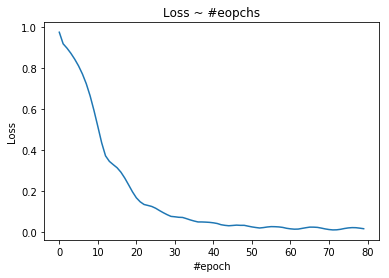

In [83]:
L = [l.item() for l in Loss]
plt.figure()
plt.xlabel('#epoch')
plt.ylabel('Loss')
plt.title('Loss ~ #eopchs')
plt.plot(list(range(max_iter)), L)

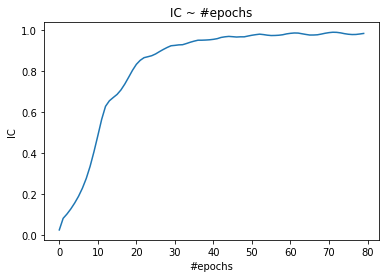

In [84]:
plt.figure()
plt.title('IC ~ #epochs')
plt.xlabel('#epochs')
plt.ylabel('IC')
plt.plot(list(range(max_iter)), coeffs)